In [85]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
df = pd.read_csv('PLANILHA IAM-UFES. - 206.csv')
df

,ID,GRUPO OFICIAL,VACINAÇÃO,Covid Longa,gênero,Idade ATUAL,raca,Unnamed: 7,VACINAÇÃO.1,SEM VACINAÇÃO
0,1,GRAVE,Não (0),SIM,FEMININO,57,Negro ou Afro americano,NaN,LEVE,LEVE
1,3,GRAVE,Não (0),NAO,MASCULINO,69,Branco,NaN,56,23
2,4,GRAVE,Não (0),SIM,MASCULINO,33,Parda,NaN,GRAVE,GRAVE
3,5,GRAVE,Não (0),SIM,MASCULINO,64,Branco,NaN,64,62
4,6,GRAVE,Não (0),SIM,MASCULINO,62,Branco,NaN,120,85
...,...,...,...,...,...,...,...,...,...,...
200,221,GRAVE,Sim (1),SIM,FEMININO,35,Parda,NaN,NaN,NaN
201,223,LEVE,Sim (1),NAO,MASCULINO,23,Branco,NaN,NaN,NaN
202,224,LEVE,Sim (1),NAO,MASCULINO,38,Parda,NaN,NaN,NaN
203,225,LEVE,Sim (1),NAO,MASCULINO,23,Branco,NaN,NaN,NaN


In [87]:
df.drop(columns=['ID', 'Unnamed: 7', 'VACINAÇÃO.1', 'SEM VACINAÇÃO'], inplace=True)
df = pd.get_dummies(df, columns=['gênero', 'raca'])
df['VACINAÇÃO'] = df['VACINAÇÃO'].replace('Sim (1)', True).replace('Não (0)', False)
df['Covid Longa'] = df['Covid Longa'].replace('SIM', True).replace('NAO', False)
df['GRUPO OFICIAL'] = df['GRUPO OFICIAL'].replace('LEVE', 1).replace('GRAVE', 2)
df

,GRUPO OFICIAL,VACINAÇÃO,Covid Longa,Idade ATUAL,gênero_FEMININO,gênero_MASCULINO,raca_Asiático,raca_Branco,raca_Negro ou Afro americano,raca_Parda
0,2,False,True,57,True,False,False,False,True,False
1,2,False,False,69,False,True,False,True,False,False
2,2,False,True,33,False,True,False,False,False,True
3,2,False,True,64,False,True,False,True,False,False
4,2,False,True,62,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
200,2,True,True,35,True,False,False,False,False,True
201,1,True,False,23,False,True,False,True,False,False
202,1,True,False,38,False,True,False,False,False,True
203,1,True,False,23,False,True,False,True,False,False


In [88]:
X = df.drop(columns=['Covid Longa'])
y = df['Covid Longa']

In [89]:
# Ranking das features para o modelo
estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=1)
selector = selector.fit(X, y)

print('Feature ranking:')
ranking = selector.ranking_
ranking = sorted(zip(ranking, X.columns))
for rank, feature in ranking:
    print(f'{rank} - {feature}')

Feature ranking:
1 - raca_Asiático
2 - raca_Parda
3 - raca_Negro ou Afro americano
4 - raca_Branco
5 - gênero_MASCULINO
6 - gênero_FEMININO
7 - VACINAÇÃO
8 - GRUPO OFICIAL
9 - Idade ATUAL


In [ ]:
model = SVC(probability=True, random_state=0)

parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

cv = KFold(n_splits=10, shuffle=True, random_state=0)
grid = GridSearchCV(model, parameters, refit=True, cv=cv, verbose=3)
grid.fit(X, y)

print(grid.best_params_)
model = grid.best_estimator_ 

Acurácia: 76.59%
Precisão: 76.73%
Sensibilidade: 99.36%
Especificidade: 4.08%
F1: 86.59%
AUC-ROC: 0.41


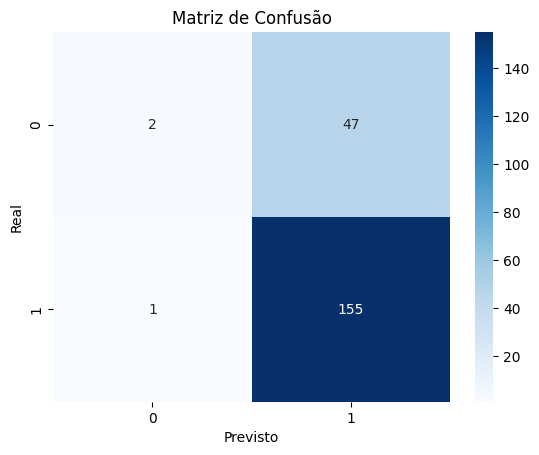

In [91]:
y_pred = cross_val_predict(model, X, y, cv=cv)
y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba') # Probabilidade das classes preditas (necessário para o cálculo da AUC-ROC)

# Cálculo das métricas
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)
auc_roc = roc_auc_score(y, y_proba[:, 1])

print(f'Acurácia: {accuracy*100:.2f}%')
print(f'Precisão: {precision*100:.2f}%')
print(f'Sensibilidade: {recall*100:.2f}%')
print(f'Especificidade: {specificity*100:.2f}%')
print(f'F1: {f1*100:.2f}%')
print(f'AUC-ROC: {auc_roc:.2f}')

sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()